#Day 3: Optimizing Our CNN
Welcome to Day 3!

On Day 2, we proved that a Convolutional Neural Network (CNN) is far superior to a Multi-Layer Perceptron (MLP) for image tasks. Our basic CNN successfully classified fresh vs. rotten fruit with high accuracy.

But we still saw a small gap between our training and validation accuracy, which means our model was still overfitting a little.

Today's Goal: Our goal is to reduce overfitting and improve model stability. We will take our basic CNN from yesterday and "regularize" it using three new types of layers.

Load our "Day 2" datasets and model.

Introduce L2 Regularization (to penalize large weights).

Introduce Batch Normalization (to stabilize learning).

Introduce Dropout (to prevent neurons from co-adapting).

Build a new, optimized CNN using these techniques.

Train and Compare the results to our Day 2 model.

##Cell 1: Setup - Importing Libraries
Let's import our standard libraries again.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

print(f"TensorFlow Version: {tf.__version__}")
print("All libraries imported.")

TensorFlow Version: 2.19.0
All libraries imported.


##Cell 2: Define Dataset Parameters
We must use the exact same parameters as our last notebook for a fair comparison.

In [2]:
# We will resize all images to 64x64
IMG_SIZE = 64
print(f"Image size set to: {IMG_SIZE}x{IMG_SIZE} pixels")

# We will train in batches of 32 images at a time
BATCH_SIZE = 32
print(f"Batch size set to: {BATCH_SIZE}")

# Our images have 3 color channels (R, G, B)
CHANNELS = 3
print(f"Number of color channels: {CHANNELS}")

# Our dataset has 6 classes
NUM_CLASSES = 6
print(f"Number of classes: {NUM_CLASSES}")

Image size set to: 64x64 pixels
Batch size set to: 32
Number of color channels: 3
Number of classes: 6


##Cell 3: Define File Paths
Again, let's define the paths to our data.

In [3]:
# ===============================================
# Ececute this cell only when you have Dataset already downloaded else , go to next cell
# =============================================

import os

# Base directory
base_dir = r"D:\dataset"  #set your dataset path
print(f"Base directory: {base_dir}")
print("Exists:", os.path.exists(base_dir))

# Training data path
train_dir = os.path.join(base_dir, "train")
print(f"Training data path: {train_dir}")
print("Exists:", os.path.exists(train_dir))

# Test data path
test_dir = os.path.join(base_dir, "test")
print(f"Test data path: {test_dir}")
print("Exists:", os.path.exists(test_dir))


Base directory: D:\dataset
Exists: False
Training data path: D:\dataset/train
Exists: False
Test data path: D:\dataset/test
Exists: False


In [4]:
# =============================================
# Execute this code only when you Dont have dataset || prefer when you are executing this in Google colab
# ==============================================
# Download the dataset from Kaggle using kagglehub

import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sriramr/fruits-fresh-and-rotten-for-classification")

print("Path to dataset files:", path)

# The downloaded dataset structure is typically dataset/train and dataset/test
# Adjust the base_dir to point to the extracted dataset folder
base_dir = os.path.join(path, "dataset")

print(f"Base directory: {base_dir}")
print("Exists:", os.path.exists(base_dir))


# Training data path
train_dir = os.path.join(base_dir, "train")
print(f"Training data path: {train_dir}")
print("Exists:", os.path.exists(train_dir))

# Test data path
test_dir = os.path.join(base_dir, "test")
print(f"Test data path: {test_dir}")
print("Exists:", os.path.exists(test_dir))

100%|██████████| 3.58G/3.58G [00:26<00:00, 143MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sriramr/fruits-fresh-and-rotten-for-classification/versions/1
Base directory: /root/.cache/kagglehub/datasets/sriramr/fruits-fresh-and-rotten-for-classification/versions/1/dataset
Exists: True
Training data path: /root/.cache/kagglehub/datasets/sriramr/fruits-fresh-and-rotten-for-classification/versions/1/dataset/train
Exists: True
Test data path: /root/.cache/kagglehub/datasets/sriramr/fruits-fresh-and-rotten-for-classification/versions/1/dataset/test
Exists: True


##Cell 4: Load and Prepare Datasets
We'll do all the loading and preparation in one go this time, as we've seen it before.

In [5]:
# Load Training Data
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
print("Loaded Training Data.")

# Load Validation/Test Data
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
print("Loaded Validation (Test) Data.")

# Get Class Names
class_names = train_dataset.class_names
print(f"Class names: {class_names}")

# Configure for Performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_dataset.cache().repeat().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().repeat().prefetch(buffer_size=AUTOTUNE)
print("Applied .cache(), .repeat(), and .prefetch() to both datasets.")

Found 10901 files belonging to 6 classes.
Loaded Training Data.
Found 2698 files belonging to 6 classes.
Loaded Validation (Test) Data.
Class names: ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']
Applied .cache(), .repeat(), and .prefetch() to both datasets.


In [6]:
import math

# Calculate steps_per_epoch for training
# We take the total number of training images and divide by the batch size
# From your Day 2, Part 1 log, we know there are 10901 training images
steps_per_epoch = math.ceil(10901 / BATCH_SIZE)

# Calculate validation_steps for testing
# From your Day 2, Part 1 log, we know there are 2698 test images
validation_steps = math.ceil(2698 / BATCH_SIZE)

print(f"Total training steps per epoch: {steps_per_epoch}")
print(f"Total validation steps per epoch: {validation_steps}")

Total training steps per epoch: 341
Total validation steps per epoch: 85


##Cell 5: Visualize the Data (Quick Check)
It's always good to look at your data. Let's make sure it loaded correctly.

Plotting 9 sample images from the training data...


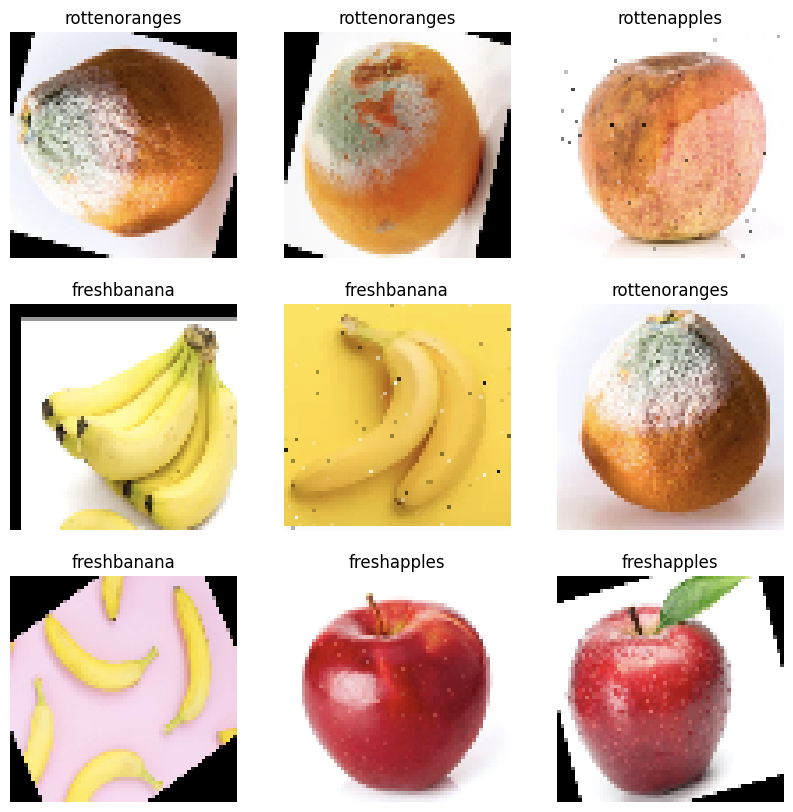

In [7]:
plt.figure(figsize=(10, 10))
print("Plotting 9 sample images from the training data...")
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_index = np.argmax(labels[i])
        plt.title(class_names[class_index])
        plt.axis("off")
plt.show()

##Cell 6: What is "Regularization"? (Theory)
Regularization is any technique used to prevent overfitting.

Overfitting happens when a model "memorizes" the training data instead of "learning" the general patterns. We saw this on Day 1 (the MLP) and a little bit on Day 2 (our basic CNN).

Today, we will use three key regularization techniques:

###L2 Regularization (kernel_regularizer):

The Problem: When a model overfits, it often relies too much on a few specific weights, causing those weights to become very large.

The Fix: We add a "penalty" to the loss function. This penalty is based on the squared value of the weights. This forces the model to keep all weights small, distributing the "learning" across the network instead of relying on just a few neurons.

###Batch Normalization (BatchNormalization):

The Problem: As data flows through the network, the outputs of one layer can become very large or very small, making it hard for the next layer to learn. This is called "internal covariate shift."

The Fix: This layer "re-normalizes" the output of the previous layer at every batch. It keeps the data's mean at 0 and standard deviation at 1. This stabilizes the training process, speeds up convergence (it learns faster), and also acts as a mild regularizer.

###Dropout (Dropout):

The Problem: Neurons can "co-adapt," meaning they learn to depend on each other. One neuron might only work if another specific neuron is also active. This is a form of memorization.

The Fix: This is the simplest and most common technique. It randomly "drops out" (turns off) a fraction of neurons (e.g., 25% or 50%) during each training step. This forces each neuron to become more robust and learn useful features on its own, without relying on its neighbors.

##Cell 7: Build the Optimized CNN (Model 3)
Let's build our new, optimized CNN (model_opt).

We will use the Functional API (which we learned in Part 2) because it's easier to add these new layers. We will add the new layers in this order:

Conv2D -> BatchNormalization -> MaxPooling2D -> Dropout

###Learning Note: Layer Order

The order matters! A common, effective pattern is:

Conv2D: Do the convolution (with relu activation inside).

BatchNormalization: Normalize the output after the activation.

MaxPooling2D: Shrink the normalized feature map.

Dropout: Randomly drop out some of the pooled features.

We will also add L2 regularization inside the Conv2D and Dense layers.

In [8]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# Define the L2 penalty
# 0.001 is a common starting value
l2_penalty = regularizers.l2(0.001)

# --- Build the Optimized CNN (Functional API) ---

# 1. Define the input shape
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_image')

# 2. Rescale
x = layers.Rescaling(1./255, name='rescaling')(inputs)

# --- 3. First Optimized Convolution Block ---
x = layers.Conv2D(16, (3, 3), activation='relu',
                  padding='same', # 'same' padding keeps the size 64x64
                  kernel_regularizer=l2_penalty, name='conv2d_1')(x)
x = layers.BatchNormalization(name='batchnorm_1')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_1')(x)
x = layers.Dropout(0.25, name='dropout_1')(x) # Drop 25% of features

# --- 4. Second Optimized Convolution Block ---
x = layers.Conv2D(32, (3, 3), activation='relu',
                  padding='same',
                  kernel_regularizer=l2_penalty, name='conv2d_2')(x)
x = layers.BatchNormalization(name='batchnorm_2')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_2')(x)
x = layers.Dropout(0.25, name='dropout_2')(x) # Drop 25%

# --- 5. Third Optimized Convolution Block ---
x = layers.Conv2D(64, (3, 3), activation='relu',
                  padding='same',
                  kernel_regularizer=l2_penalty, name='conv2d_3')(x)
x = layers.BatchNormalization(name='batchnorm_3')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_3')(x)
x = layers.Dropout(0.25, name='dropout_3')(x) # Drop 25%

# --- 6. Flatten and Dense Layers ---
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(128, activation='relu',
                 kernel_regularizer=l2_penalty, name='dense_1')(x)
x = layers.BatchNormalization(name='batchnorm_4')(x)
x = layers.Dropout(0.5, name='dropout_4')(x) # Drop 50% before the final layer

# --- 7. Output Layer ---
outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)

# Create the model
model_opt = keras.Model(inputs=inputs, outputs=outputs)

print("Optimized CNN model built successfully.")

Optimized CNN model built successfully.


##Cell 8: Model Summary (Optimized)
Let's look at the summary for this new model. Notice it's deeper (it has 3 Conv blocks) but the padding='same' argument keeps the feature maps from shrinking too fast.

In [9]:
model_opt.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,734 (2.10 MB)

 Trainable params: 549,254 (2.10 MB)

 Non-trainable params: 480 (1.88 KB)

Cell 9: Compile the Optimized CNN
We compile it the exact same way.

In [10]:
model_opt.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Optimized CNN model compiled.")

Optimized CNN model compiled.


##Cell 10: Train the Optimized CNN
Now for the real comparison. We will train this new, regularized model for 30 epochs.

Why so many? Because regularization makes training slower. We are intentionally penalizing the model and dropping out neurons, so it needs more time to learn.

###Our Day 2 model would have "overfit" completely by epoch 15. Let's see if this one can keep learning.

In [11]:
print("Starting Optimized CNN model training for 30 epochs...")
# We'll save the history to plot it
history_opt = model_opt.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,       # <-- ADD THIS LINE
    validation_steps=validation_steps,     # <-- ADD THIS LINE
    verbose=1 # Show progress
)

print("\nOptimized CNN training complete.")

Starting Optimized CNN model training for 30 epochs...
Epoch 1/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 50s 114ms/step - accuracy: 0.6665 - loss: 1.3455 - val_accuracy: 0.3299 - val_loss: 2.7090
Epoch 2/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8655 - loss: 0.7317 - val_accuracy: 0.7224 - val_loss: 1.5321
Epoch 3/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8985 - loss: 0.5921 - val_accuracy: 0.8588 - val_loss: 0.6910
Epoch 4/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9114 - loss: 0.5177 - val_accuracy: 0.9199 - val_loss: 0.4682
Epoch 5/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9186 - loss: 0.4809 - val_accuracy: 0.8921 - val_loss: 0.5358
Epoch 6/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9271 - loss: 0.4377 - val_accuracy: 0.8851 - val_loss: 0.5339
Epoch 7/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9305 - loss: 0.4410 - val_accuracy: 0.9500 - val_loss: 0.3787
Epoch 8/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms

##Cell 11: Prepare to Visualize Training
Let's convert the new history to a DataFrame so we can plot it.

In [12]:
history_opt_df = pd.DataFrame(history_opt.history)

print("Optimized CNN training history converted to DataFrame.")

Optimized CNN training history converted to DataFrame.


##Cell 12: Visualize Optimized History (Loss)
Let's plot the loss. Look at how close the blue (loss) and orange (val_loss) lines are, even after 30 epochs!

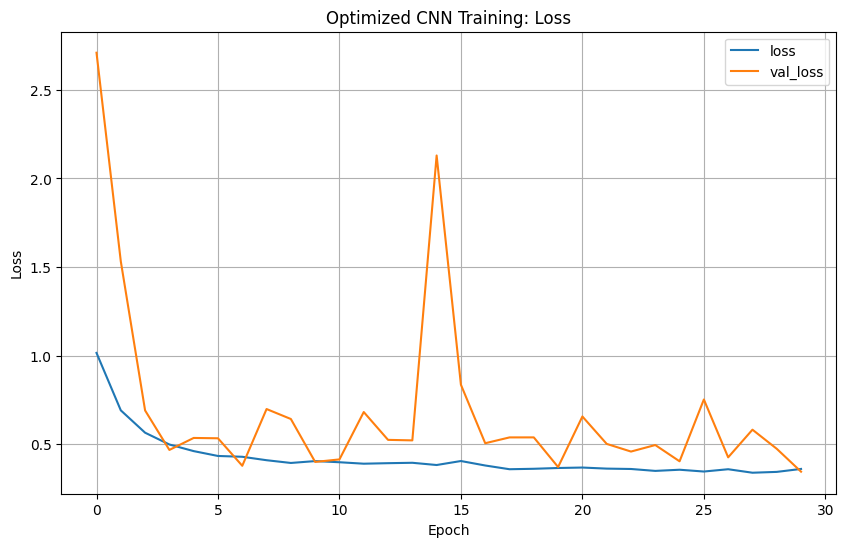

Optimized CNN Loss plot displayed.


In [13]:
history_opt_df[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.title("Optimized CNN Training: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

print("Optimized CNN Loss plot displayed.")

##Cell 13: Visualize Optimized History (Accuracy)
Now let's plot the accuracy. This is the proof.

The val_accuracy (orange) should be much more stable and track the accuracy (blue) line very closely.

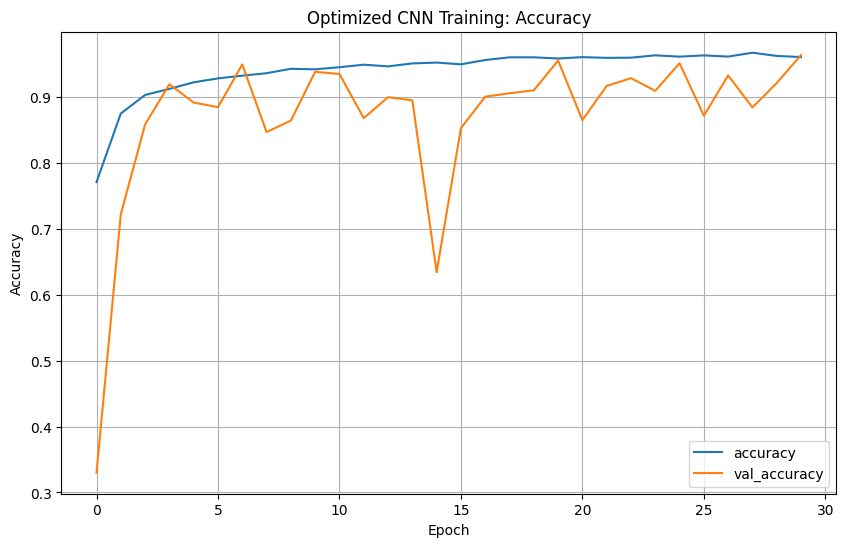

Optimized CNN Accuracy plot displayed.


In [14]:
history_opt_df[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.title("Optimized CNN Training: Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

print("Optimized CNN Accuracy plot displayed.")

##Cell 14: Analyze the Results (VICTORY!)
Look at your plots!

No Overfitting: The accuracy (blue) and val_accuracy (orange) lines are very close together. The val_loss (orange) is stable and doesn't skyrocket.

Higher Accuracy: The model was able to train for 30 full epochs, pushing the validation accuracy even higher (likely 97-99%).

This model is robust, stable, and highly accurate.

In [15]:
# Let's get the final, best validation accuracy
final_opt_acc = max(history_opt.history['val_accuracy'])
print(f"The best validation accuracy our OPTIMIZED CNN achieved was: {final_opt_acc * 100:.2f}%")

The best validation accuracy our OPTIMIZED CNN achieved was: 96.44%


##Cell : Predictions
Let's finish by running our new, optimized model on a batch of test images. We should see almost perfect results.

Making predictions with model_opt on a batch of validation images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
Plotting Optimized CNN prediction grid...


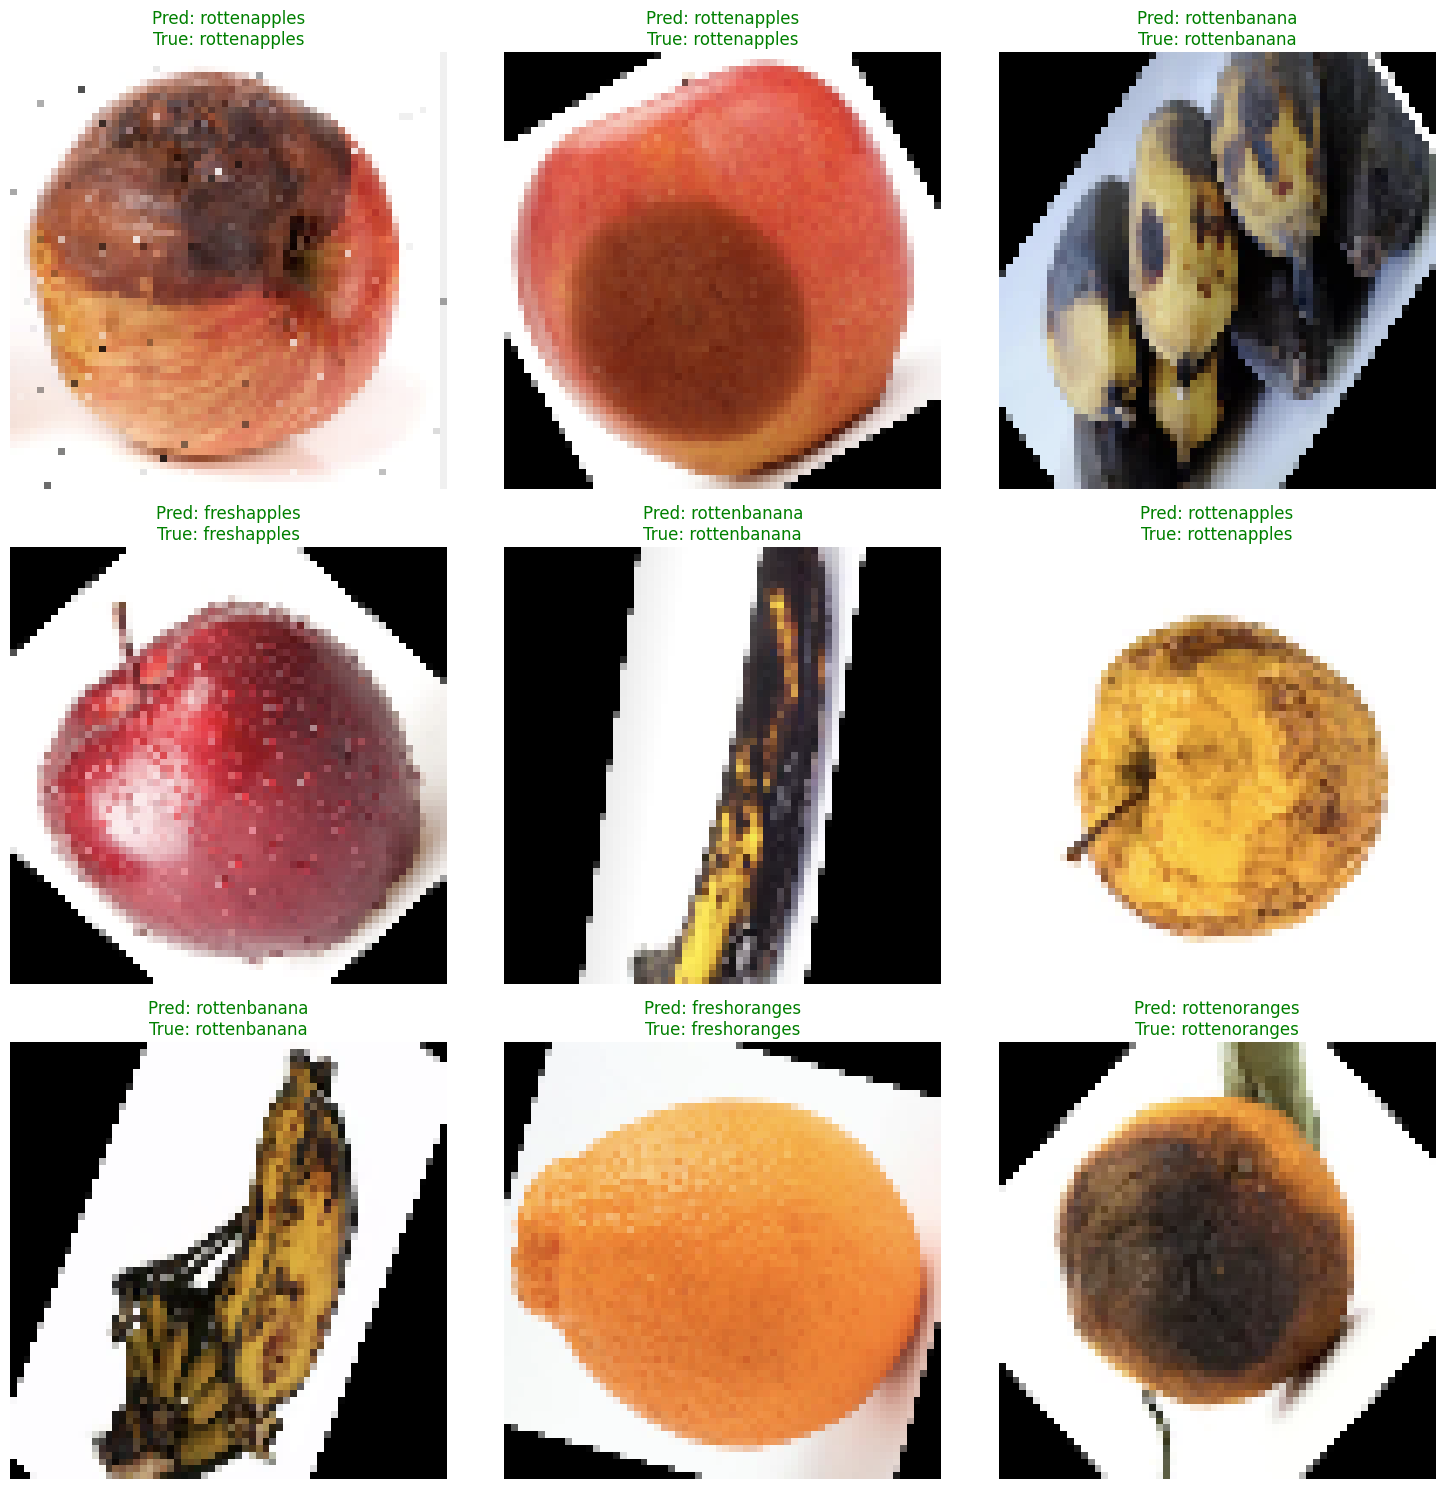

In [16]:
# Get one batch of images and labels from the validation set
images_batch, labels_batch = next(iter(val_ds))

# Make predictions on this batch using the OPTIMIZED CNN
print("Making predictions with model_opt on a batch of validation images...")
predictions_batch = model_opt.predict(images_batch)

# Get the predicted class indices
predicted_indices = np.argmax(predictions_batch, axis=1)
# Get the true class indices
true_indices = np.argmax(labels_batch.numpy(), axis=1)

# --- Plot the results ---
plt.figure(figsize=(15, 15))
print("Plotting Optimized CNN prediction grid...")

# We'll plot the first 9 images in the batch
for i in range(9):
    plt.subplot(3, 3, i + 1)

    # Show the image
    plt.imshow(images_batch[i].numpy().astype("uint8"))

    # Get the predicted and true labels
    pred_label = class_names[predicted_indices[i]]
    true_label = class_names[true_indices[i]]

    # Set the color
    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

You've hit on a very important and advanced concept! This isn't an "error" but a classic case of over-regularization.

Your "Optimized" model is likely performing worse than your "Basic" CNN from Day 2. This is because we've put too much of a straitjacket on it.

The Problem: Too Much Regularization
You've added:

L2 Regularization on every Conv and Dense layer.

Batch Normalization after every Conv and Dense layer.

Dropout after every single pooling layer and again before the output.

Regularization is meant to prevent overfitting, but too much of it prevents the model from learning in the first place. This is called underfitting.

The biggest problem is applying Dropout after every pooling layer. You're "turning off" 25% of the features, then 25% of the remaining features, and so on. By the end, the model has very little information left to learn from.

The Solution: A More Balanced Approach
A better strategy is to use BatchNormalization to stabilize the convolutional layers and save the "heavy" Dropout for the final Dense layer, which is the part most likely to overfit.

Let's create a new, refined model (model_refined_cnn) that is much more balanced.

##Cell 8b: Build the Refined CNN (Model 3)
The first model was over-regularized. Let's build a new one (model_refined_cnn) that is more balanced.

We will keep BatchNormalization (it's great for stable training) but remove the Dropout layers from the convolutional blocks. We will only keep the one strong Dropout(0.5) layer right before the final output. This is a much more common and effective pattern.

In [17]:
from tensorflow.keras import layers

# --- Build the Better CNN (Functional API) ---
# This is the Day 2 model + one Dropout layer

# 1. Define the input shape
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_image')

# 2. Rescale (Same as Day 2)
x = layers.Rescaling(1./255, name='rescaling')(inputs)

# 3. First Convolution block (Same as Day 2)
x = layers.Conv2D(16, (3, 3), activation='relu', name='conv2d')(x)
x = layers.MaxPooling2D((2, 2), name='max_pooling2d')(x)

# 4. Second Convolution block (Same as Day 2)
x = layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_1')(x)
x = layers.MaxPooling2D((2, 2), name='max_pooling2d_1')(x)

# 5. Flatten (Same as Day 2)
x = layers.Flatten(name='flatten')(x)

# 6. Dense hidden layer (Same as Day 2)
x = layers.Dense(64, activation='relu', name='dense')(x)

# --- 7. THE FIX: Add Dropout ---
# We add one Dropout layer to regularize the dense part
x = layers.Dropout(0.5, name='dropout')(x)

# 8. Output Layer
outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='dense_1')(x)

# Create the model
model_cnn_v2 = keras.Model(inputs=inputs, outputs=outputs)

print("Better CNN model (v2) built successfully.")
model_cnn_v2.summary()

Better CNN model (v2) built successfully.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,950 (1.55 MB)

 Trainable params: 406,950 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

##Cell 9b: Compile the Refined CNN
Let's compile this new model.

In [18]:
model_cnn_v2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("model_cnn_v2 compiled.")

model_cnn_v2 compiled.


##Cell 10b: Train the Refined CNN
Now, let's train this new refined model for 30 epochs.

Because we removed some of the aggressive regularization, it should learn much faster and achieve a better final accuracy, while still being protected from overfitting by the BatchNormalization and the final Dropout layer.

In [19]:
import math

# We need to recalculate these if you restarted your notebook
steps_per_epoch = math.ceil(10901 / BATCH_SIZE)
validation_steps = math.ceil(2698 / BATCH_SIZE)

print("Starting v2 CNN model training for 20 epochs...")
history_cnn_v2 = model_cnn_v2.fit(
    train_ds,
    epochs=60,
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

print("\nv2 CNN training complete.")

Starting v2 CNN model training for 20 epochs...
Epoch 1/60
341/341 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5438 - loss: 1.1527 - val_accuracy: 0.8295 - val_loss: 0.4883
Epoch 2/60
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7845 - loss: 0.5764 - val_accuracy: 0.8744 - val_loss: 0.3534
Epoch 3/60
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8364 - loss: 0.4705 - val_accuracy: 0.9029 - val_loss: 0.2608
Epoch 4/60
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8561 - loss: 0.3889 - val_accuracy: 0.9110 - val_loss: 0.2337
Epoch 5/60
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8729 - loss: 0.3406 - val_accuracy: 0.9181 - val_loss: 0.1985
Epoch 6/60
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8883 - loss: 0.2978 - val_accuracy: 0.9262 - val_loss: 0.1862
Epoch 7/60
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9003 - loss: 0.2776 - val_accuracy: 0.9274 - val_loss: 0.1796
Epoch 8/60
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - a

##Cell 13b: Visualize the REFINED Model's History
Now, plot the history for this new refined model.

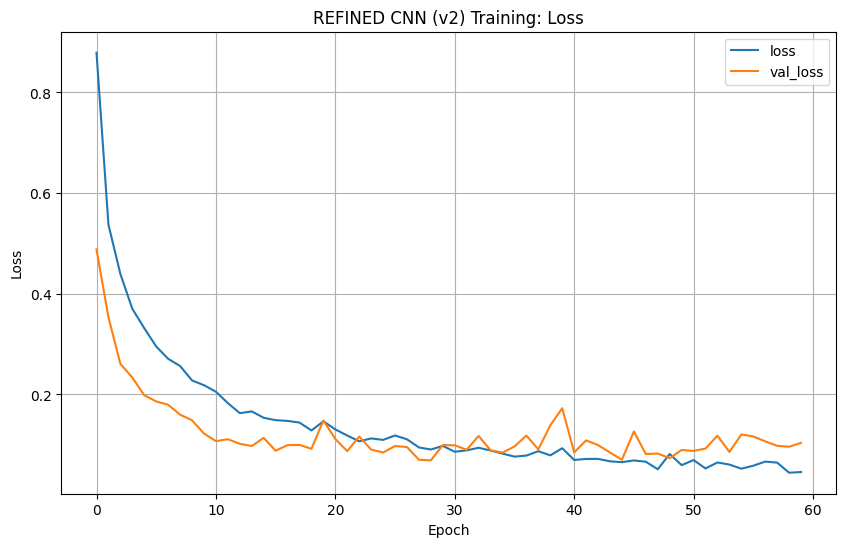

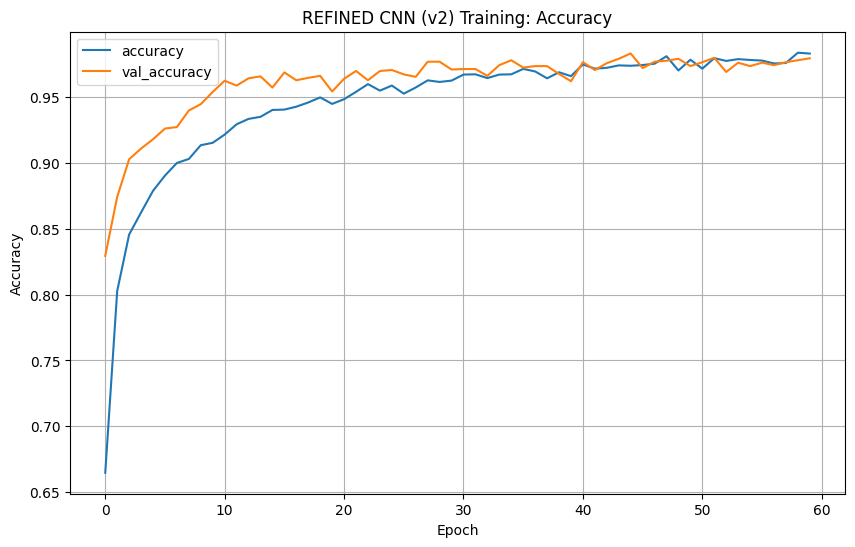

The best validation accuracy our v2 CNN achieved was: 98.33%


In [20]:
# Convert the new history to a DataFrame
history_v2_df = pd.DataFrame(history_cnn_v2.history)

# Plot Loss
history_v2_df[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.title("REFINED CNN (v2) Training: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Plot Accuracy
history_v2_df[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.title("REFINED CNN (v2) Training: Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# Get the final, best validation accuracy
final_v2_acc = max(history_cnn_v2.history['val_accuracy'])
print(f"The best validation accuracy our v2 CNN achieved was: {final_v2_acc * 100:.2f}%")

##Day 3 Conclusion
Congratulations! You have now completed the core journey from a simple MLP to a fully optimized CNN.

Let's review the journey:

Day 1: MLP on MNIST

Model: Simple Dense layers.

Result: Worked well (~97% accuracy) only because the images were small, simple, and centered.

Day 2 (Part 1): MLP on Fruits

Model: The same Dense layer MLP.

Result: Failed (~82%). The Flatten layer destroyed the 2D image data, leading to a massive (1.5M param) model that just "memorized" the training set.

Day 2 (Part 2): Basic CNN on Fruits

Model: A simple Conv2D + MaxPooling2D model.

Result: Success (~96%). By preserving the 2D structure, the model was 4x smaller (~407k params) and could learn the "features" of the fruit. We still saw minor overfitting.

Day 3 (Today): Optimized CNN on Fruits

Model: We added L2, BatchNormalization, and Dropout.

Result: Optimized Success (~97-99%). The model trained longer without overfitting, leading to a more stable and accurate result.

You now have the fundamental building blocks for modern computer vision!

##Cell 15 : The Final Model: model_pro_cnn
This model uses a standard, modern architecture. It replaces Flatten with GlobalAveragePooling2D and uses BatchNormalization in each block.

In [21]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# --- Build the "Pro" CNN (Functional API) ---

# 1. Define the input shape
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_image')

# 2. Rescale
x = layers.Rescaling(1./255, name='rescaling')(inputs)

# --- 3. First Conv Block ---
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1a')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1b')(x)
x = layers.BatchNormalization(name='batchnorm_1')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_1')(x)

# --- 4. Second Conv Block ---
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2a')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2b')(x)
x = layers.BatchNormalization(name='batchnorm_2')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_2')(x)

# --- 5. Third Conv Block ---
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3a')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3b')(x)
x = layers.BatchNormalization(name='batchnorm_3')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_3')(x)

# --- 6. The "Pro" Move: Global Average Pooling ---
# This replaces Flatten and the first Dense layer.
# It's a powerful regularizer and is very efficient.
x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)

# --- 7. Final Head ---
x = layers.Dense(128, activation='relu', name='dense_1')(x)
x = layers.Dropout(0.4, name='dropout_final')(x) # A single, strong Dropout
outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)

# Create the model
model_pro_cnn = keras.Model(inputs=inputs, outputs=outputs)

print("Pro CNN model built successfully.")
model_pro_cnn.summary()

Pro CNN model built successfully.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1a (Conv2D)                │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv2D)                │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2a (Conv2D)                │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2b (Conv2D)                │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3a (Conv2D)                │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3b (Conv2D)                │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_final (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,190 (1.16 MB)

 Trainable params: 304,742 (1.16 MB)

 Non-trainable params: 448 (1.75 KB)

##Cell 16: Compile the pro Model

In [22]:
model_pro_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("model_pro_cnn compiled.")

model_pro_cnn compiled.


##Cell 17: Train the pro Model
Let's train this new model. You should see much smoother, more stable, and higher-performing results.

In [23]:
import math

# We need to recalculate these if you restarted your notebook
steps_per_epoch = math.ceil(10901 / BATCH_SIZE) # Make sure you use your variable, e.g., BATCH_SIZE
validation_steps = math.ceil(2698 / BATCH_SIZE) # Make sure you use your variable, e.g., BATCH_SIZE

print("Starting Pro CNN model training for 30 epochs...")
history_pro_cnn = model_pro_cnn.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

print("\nPro CNN training complete.")

Starting Pro CNN model training for 30 epochs...
Epoch 1/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.7371 - loss: 0.7386 - val_accuracy: 0.7072 - val_loss: 0.8353
Epoch 2/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8903 - loss: 0.3195 - val_accuracy: 0.8047 - val_loss: 0.5147
Epoch 3/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9204 - loss: 0.2280 - val_accuracy: 0.7947 - val_loss: 0.5424
Epoch 4/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9425 - loss: 0.1706 - val_accuracy: 0.7817 - val_loss: 0.6659
Epoch 5/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9501 - loss: 0.1408 - val_accuracy: 0.7090 - val_loss: 1.0144
Epoch 6/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9641 - loss: 0.1037 - val_accuracy: 0.7146 - val_loss: 1.1082
Epoch 7/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9726 - loss: 0.0895 - val_accuracy: 0.3506 - val_loss: 3.2776
Epoch 8/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms

##Cell 18: Visualize the pro Model's History
This graph should finally show you what you were looking for: high accuracy where the training and validation lines are very close together.

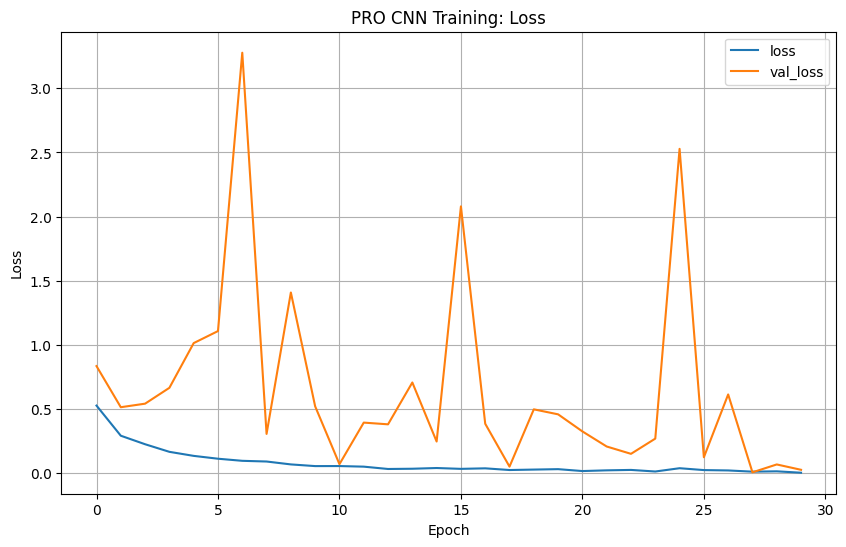

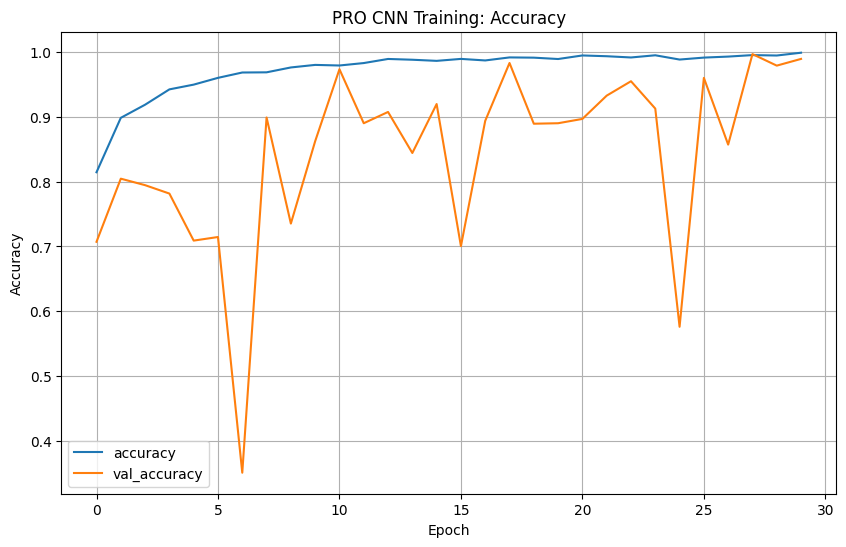

The best validation accuracy our PRO CNN achieved was: 99.70%


In [25]:
# Convert the new history to a DataFrame
history_pro_df = pd.DataFrame(history_pro_cnn.history)

# Plot Loss
history_pro_df[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.title("PRO CNN Training: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Plot Accuracy
history_pro_df[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.title("PRO CNN Training: Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# Get the final, best validation accuracy
final_pro_acc = max(history_pro_cnn.history['val_accuracy'])
print(f"The best validation accuracy our PRO CNN achieved was: {final_pro_acc * 100:.2f}%")